# The Wah Sampler

Convert your favorite music to the wah-nderful sound effects of Waluigi

In [1]:
import librosa
from IPython.display import Audio
import matplotlib.mlab as mlab
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from typing import Tuple
import music21

## Base "Wah" Sound
This is the clip of Waluigi, the Nintendo character and our team mascot's, trademark "Wah!" Why don't we take a listen?

In [2]:
wah_og, sampling_rate = librosa.load("waluigi_wahring2mob.wav", sr=44100, mono=True)
Audio(wah_og, rate=sampling_rate)

### Spectrogram

This is a spectrogram representation of the "Wah". It visualizes the frequencies in the sounds along with their amplitudes

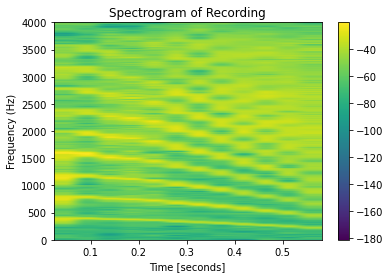

In [3]:
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    wah_og,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
)
fig.colorbar(im)

ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Recording")
ax.set_ylim(0, 4000);

## Music: Fur Waluigi
This is a midi file which stores a simple excerpt of Fur Elise done on piano. 
Midi files store information suhc as what notes the music has, as well as beat, tempo, akey, etc.
This is the standard way of reperesenting music, especially instrumental.

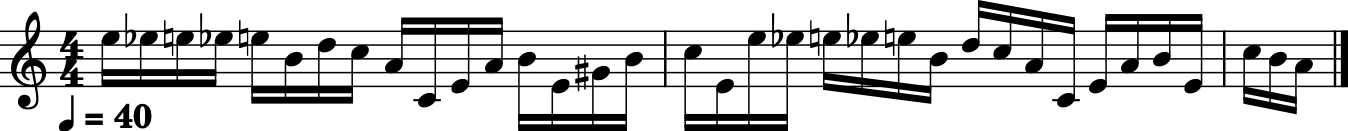

In [4]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi("fur_waluigi.midi", True)
base_midi.show()
base_midi.show('midi')

### Extracting the Notes and Displaying Them
These two functions extract the western notes played in the clip and diplay them in a plot. 
The plot shows the notes in terms of where they appear temporal and what scientific pitch notatation they are at.

<a href="https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies">Pitch and Octave Number Table</a>

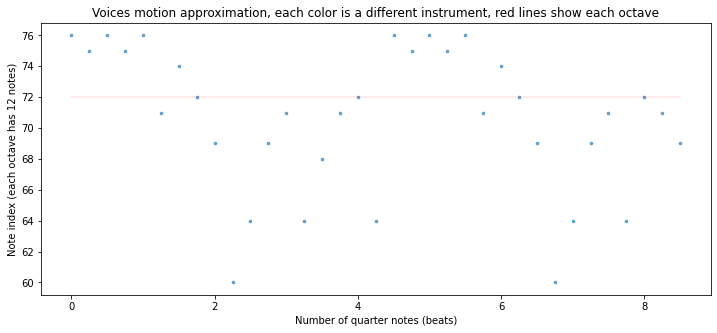

In [5]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()


notes = extract_notes(base_midi)
print_parts_countour(base_midi)

### Playing the Music in Wahs

This code essentially replaces every note in the piece with the "Wah" clip from before. 
To adjust the pitch to match the given note, the frequency of the wah sound is converted to the frequency of the music note.
The original frequency of the "Wah" was found to be 380, and the note frequencies are determined by the Music21 library functions.
A librosa function was used to adjust the length of the clip to match different beat lengths in a music piece. The half-second long "Wah" is taken to be a quarter note. To get a half note, the length is doubled and to get an eighth note, the length is halved. 

The adjusted "Wahs" are then concatenated back into the original piece's pattern and played.

In [6]:
length_dict = {'whole': 0.25, 'half': 0.5, 'quarter': 1, 'eighth' : 2,'16th' : 4 }

length = len(notes[0])
wah_music = []
wahirginal = 380
for i in range(0, length):
    note = notes[1][i]
    target_freq = note.pitch.frequency
    steps = 12*np.log(target_freq/wahirginal)/np.log(2)
    wah_note = librosa.effects.pitch_shift(wah_og, sampling_rate, n_steps=steps)
    wah_note_time = librosa.effects.time_stretch(wah_note, length_dict[note.duration.type])
    wah_music.append(wah_note_time)
wah_concat = np.concatenate(wah_music)
Audio(wah_concat, rate=sampling_rate)

## Music: Hot Waluigi Buns

To showcase the ability of the program to replicate music pieces without uniform note lengths, the same process is repeated for the song "Hot Cross Buns"

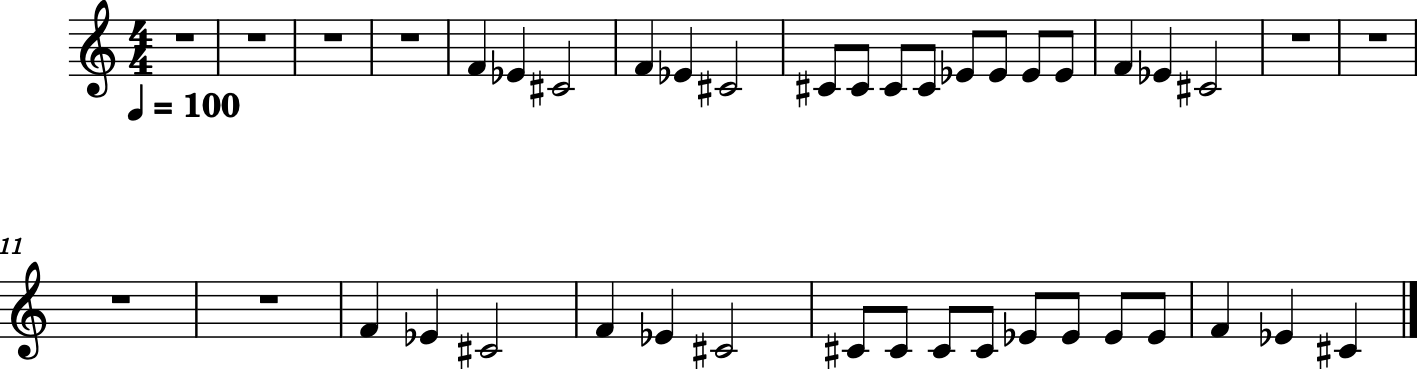

In [7]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

bun_midi = open_midi("hot_cross_buns.midi", True)
bun_midi.show()
bun_midi.show('midi')

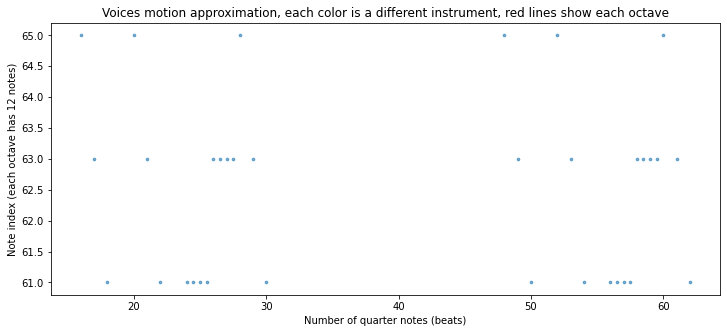

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

bun_notes = extract_notes(bun_midi)
print_parts_countour(bun_midi)

In [9]:
length_dict = {'whole': 0.25, 'half': 0.5, 'quarter': 1, 'eighth' : 2,'16th' : 4 }
length = len(bun_notes[0])
wah_music = []
wahirginal = 380
for i in range(0, length):
    note = bun_notes[1][i]
    target_freq = note.pitch.frequency
    steps = 12*np.log(target_freq/wahirginal)/np.log(2)
    wah_note = librosa.effects.pitch_shift(wah_og, sampling_rate, n_steps=steps)
    wah_note_time = librosa.effects.time_stretch(wah_note, length_dict[note.duration.type])
    wah_music.append(wah_note_time)
wah_concat = np.concatenate(wah_music)
Audio(wah_concat, rate=sampling_rate)